## The Project (Birds eye view)

### 1) Prepare the data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root="./data/FashionMNIST",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

In [3]:
test_set = torchvision.datasets.FashionMNIST(
    root="./data/FashionMNIST",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

In [5]:
len(train_set)

60000

In [6]:
len(test_set)

10000

In [7]:
train_set.train_labels

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
test_set.test_labels

tensor([9, 2, 1,  ..., 8, 1, 5])

In [9]:
train_set.train_labels.bincount()  # every class has 6000 image in training set

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [10]:
test_set.test_labels.bincount()

tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

`Class imbalance is a common problem, but in our case , we just seen that the fashion mnist dataset is indeed balanced.`

In [11]:
sample = next(iter(train_set))

In [12]:
len(sample)

2

In [13]:
type(sample)

tuple

In [14]:
image, label = sample

In [15]:
image.shape

torch.Size([1, 28, 28])

Label: 9


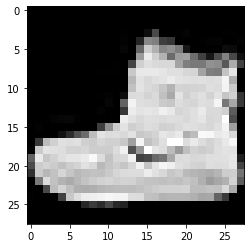

In [16]:
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

torch.Size([28, 28])

In [17]:
batch = next(iter(train_loader))

In [18]:
len(batch)

2

In [19]:
type(batch)

list

In [20]:
images, labels = batch

In [21]:
images.shape

torch.Size([10, 1, 28, 28])

In [22]:
labels.shape

torch.Size([10])

In [23]:
l = [1, 2, 3, 4]
it = iter(l)
print(it)
next(it)
next(it)

2

Labels:  tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


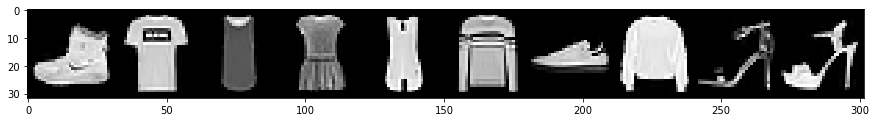

In [24]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("Labels: ", labels)

### 2) Build the model

In [25]:
import torch.nn as nn
import torch.nn.functional as F

In [27]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, input):
        # (1) input layer
        input = input

        # (2) hidden conv layer
        x = self.conv1(input)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # (3) hidden conv layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # (4) hidden linear layer
        x = x.reshape(-1, 12 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)

        # (5) hidden linear layer
        x = self.fc2(x)
        x = F.relu(x)

        # (6) output linear layer
        x = self.out(x)
        #x = F.softmax(x, dim=1)

        return x
        

In [28]:
net = Network()

In [29]:

print(net)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [30]:
class Net(): ## basically this Network class automatically inherit from object class
    pass

In [33]:
class Net(object): ## we show this manually
    def __init__(self):
        pass
    def __repr__(self):
        return "Raw class" # print(Net())
    def __call__(self, x): # by this magic method you can call the instance of Net class
        return x

In [34]:
    n = Net()
    print(n)
    print(n(10)) # this object is a callable object


Raw class
10


In [35]:
net.conv1

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))

In [36]:
net.conv2

Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))

In [37]:
net.fc1

Linear(in_features=192, out_features=120, bias=True)

In [38]:
net.out

Linear(in_features=60, out_features=10, bias=True)

In [39]:
net.conv1.weight.shape

torch.Size([6, 1, 5, 5])

In [40]:
net.out.weight.shape

torch.Size([10, 60])

 PyTorch layers object are callable object.

### 3) Train the model

In [41]:
import torch.optim as optim

In [42]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [43]:
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [44]:
EPOCHS = 1

In [50]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print("Epoch: ", epoch + 1)

print('Finished Training')

[1,  2000] loss: 0.534
[1,  4000] loss: 0.515
[1,  6000] loss: 0.529
Epoch:  1
Finished Training


### 4) Loading the trained model

In [45]:
net.load_state_dict(torch.load("./fashionist.pth"))

<All keys matched successfully>

### 5) Analysing the model

In [46]:
len(train_set)

60000

In [47]:
len(train_set.targets)

60000

#### getting training for the entire training set

In [48]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
         
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [49]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
train_preds = get_all_preds(net, prediction_loader)

In [50]:
train_preds.shape

torch.Size([60000, 10])

In [51]:
print(train_preds.requires_grad)

True


In [52]:
train_preds.grad

In [53]:
train_preds.grad_fn

### predicting without gradients tracking

In [54]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(net, prediction_loader)
    

In [55]:
train_preds.shape

torch.Size([60000, 10])

In [56]:
train_preds.grad

In [57]:
train_preds.requires_grad

False

In [65]:
preds_correct = get_num_correct(train_preds, train_set.targets)

In [66]:
print("Total_Correct: ", preds_correct)

Total_Correct:  49222


In [67]:
print("Accuracy: ", preds_correct/len(train_set))

Accuracy:  0.8203666666666667


### Building confusion matrix

In [68]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [69]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [70]:
stacked = torch.stack((
    train_set.targets,
    train_preds.argmax(dim=1)               # pair of (true_label, predicted_label)
), dim=1)

In [72]:
stacked.shape

torch.Size([60000, 2])

In [73]:
stacked[0].tolist()

[9, 9]

In [80]:
cmt = torch.zeros(10, 10, dtype=torch.int64)

In [81]:
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [82]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [83]:
cmt

tensor([[5145,   23,  224,  352,   12,   46,  137,    0,   61,    0],
        [  56, 5427,   81,  234,    1,  154,   40,    0,    7,    0],
        [  78,    5, 4460,   67, 1048,   73,  216,    0,   53,    0],
        [ 158,   46,  119, 5167,  352,   93,   60,    1,    3,    1],
        [  11,    3,  866,  293, 4346,   13,  451,    1,   16,    0],
        [   0,    0,    6,    0,    0, 5646,    0,  275,    0,   73],
        [1721,    7, 1256,  294,  519,   47, 2016,    0,  140,    0],
        [   0,    0,    0,    0,    0,  128,    0, 5745,    0,  127],
        [  17,    1,  118,   25,   17,  149,   45,   10, 5617,    1],
        [   0,    0,    1,    0,    0,   67,    0,  273,    6, 5653]])

#### plotting confustion matrix

In [85]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from resources.plotcm import plot_confusion_matrix

In [86]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))

In [87]:
print(type(cm))
print(cm)

<class 'numpy.ndarray'>
[[5145   23  224  352   12   46  137    0   61    0]
 [  56 5427   81  234    1  154   40    0    7    0]
 [  78    5 4460   67 1048   73  216    0   53    0]
 [ 158   46  119 5167  352   93   60    1    3    1]
 [  11    3  866  293 4346   13  451    1   16    0]
 [   0    0    6    0    0 5646    0  275    0   73]
 [1721    7 1256  294  519   47 2016    0  140    0]
 [   0    0    0    0    0  128    0 5745    0  127]
 [  17    1  118   25   17  149   45   10 5617    1]
 [   0    0    1    0    0   67    0  273    6 5653]]


Confusion matrix, without normalization
[[5145   23  224  352   12   46  137    0   61    0]
 [  56 5427   81  234    1  154   40    0    7    0]
 [  78    5 4460   67 1048   73  216    0   53    0]
 [ 158   46  119 5167  352   93   60    1    3    1]
 [  11    3  866  293 4346   13  451    1   16    0]
 [   0    0    6    0    0 5646    0  275    0   73]
 [1721    7 1256  294  519   47 2016    0  140    0]
 [   0    0    0    0    0  128    0 5745    0  127]
 [  17    1  118   25   17  149   45   10 5617    1]
 [   0    0    1    0    0   67    0  273    6 5653]]


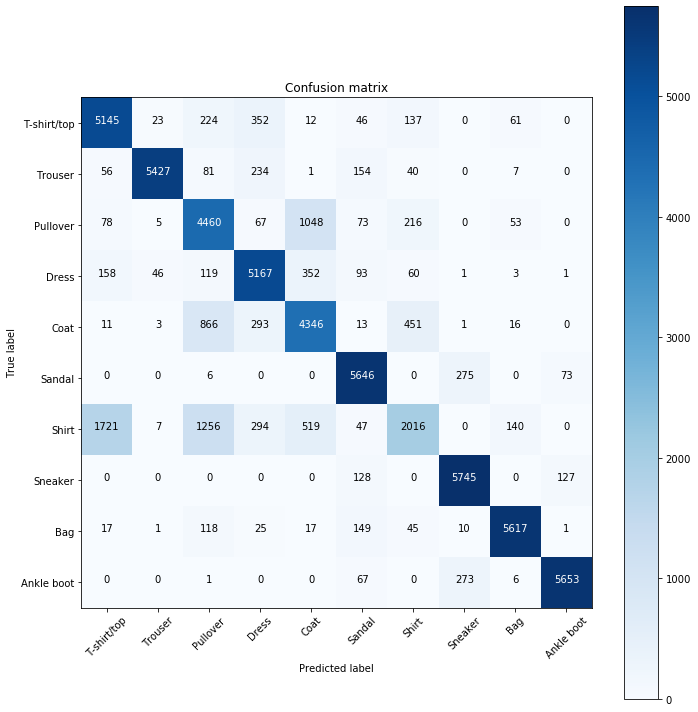

In [89]:
names = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, names)

#### Confusion matrix for test set

In [90]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_set, batch_size=128)
    test_preds = get_all_preds(net, prediction_loader)
    

In [91]:
test_preds.shape

torch.Size([10000, 10])

In [99]:
preds_correct = get_num_correct(test_preds, test_set.targets)

In [100]:

print("Total Corrects: ", preds_correct)

Total Corrects:  8137


In [101]:
print("Accuracy: ", preds_correct / len(test_set))

Accuracy:  0.8137


In [92]:
stacked = torch.stack((
    test_set.targets,
    test_preds.argmax(dim=1)
), dim=1)

In [93]:
cmt = torch.zeros(10, 10, dtype=torch.int64)

In [94]:
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [95]:
for c in stacked:
    al, pl = c
    cmt[al, pl] = cmt[al, pl] + 1

In [96]:
cmt

tensor([[847,   2,  42,  64,   5,   4,  18,   0,  17,   1],
        [ 13, 892,  15,  39,   3,  20,  14,   0,   4,   0],
        [ 17,   1, 758,  10, 161,   9,  34,   0,  10,   0],
        [ 28,   8,  27, 854,  53,  17,  11,   0,   0,   2],
        [  1,   1, 159,  38, 704,   8,  87,   0,   2,   0],
        [  0,   0,   0,   0,   0, 944,   0,  41,   0,  15],
        [280,   4, 212,  63,  95,   8, 309,   0,  29,   0],
        [  0,   0,   0,   0,   0,  17,   0, 967,   0,  16],
        [  0,   0,  25,   6,   3,  30,   5,   4, 926,   1],
        [  0,   0,   0,   0,   0,  12,   1,  50,   1, 936]])

Confusion matrix, without normalization
tensor([[847,   2,  42,  64,   5,   4,  18,   0,  17,   1],
        [ 13, 892,  15,  39,   3,  20,  14,   0,   4,   0],
        [ 17,   1, 758,  10, 161,   9,  34,   0,  10,   0],
        [ 28,   8,  27, 854,  53,  17,  11,   0,   0,   2],
        [  1,   1, 159,  38, 704,   8,  87,   0,   2,   0],
        [  0,   0,   0,   0,   0, 944,   0,  41,   0,  15],
        [280,   4, 212,  63,  95,   8, 309,   0,  29,   0],
        [  0,   0,   0,   0,   0,  17,   0, 967,   0,  16],
        [  0,   0,  25,   6,   3,  30,   5,   4, 926,   1],
        [  0,   0,   0,   0,   0,  12,   1,  50,   1, 936]])


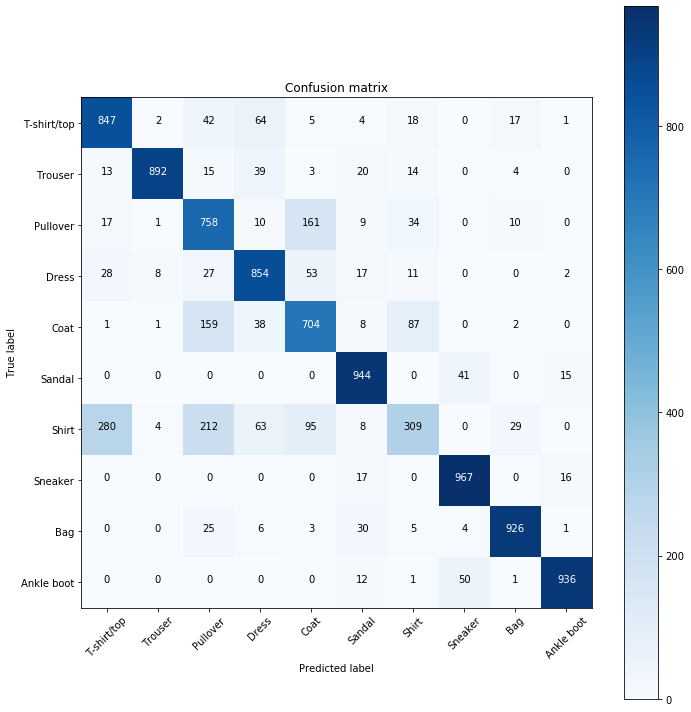

In [103]:
names = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cmt, names)

#### Building run builder

In [2]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product

In [14]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run', params.keys())
        runs = []
        for v in product(*params.values()):
           runs.append(Run(*v))

        return runs

In [15]:
params = OrderedDict(
    lr = [.01,.001],
    batch_size = [128, 256]
)

In [16]:
params.keys()

odict_keys(['lr', 'batch_size'])

In [17]:
params.values()

odict_values([[0.01, 0.001], [128, 256]])

In [18]:
runs = RunBuilder.get_runs(params)

In [19]:
runs

[Run(lr=0.01, batch_size=128),
 Run(lr=0.01, batch_size=256),
 Run(lr=0.001, batch_size=128),
 Run(lr=0.001, batch_size=256)]

In [21]:
run = runs[0]

In [22]:
run.lr

0.01

In [23]:
run.batch_size

128